In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=1e-3
LEARNING_RATE = .00005

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 500 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


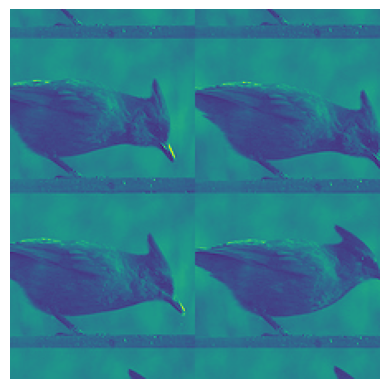

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [5]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.000050, Loss: 0.9408


Epoch 1, Batch 2, LR: 0.000050, Loss: 0.9394


Epoch 1, Batch 3, LR: 0.000050, Loss: 0.8084


Epoch 1, Batch 4, LR: 0.000050, Loss: 0.7449


Epoch 1, Batch 5, LR: 0.000050, Loss: 0.7214


Epoch 1, Batch 6, LR: 0.000050, Loss: 0.6968


Epoch 1, Batch 7, LR: 0.000050, Loss: 0.7007


Epoch 1, Batch 8, LR: 0.000050, Loss: 0.6593


Epoch 1, Batch 9, LR: 0.000050, Loss: 0.6563


Epoch 1, Batch 10, LR: 0.000050, Loss: 0.6636


Epoch 1, Batch 11, LR: 0.000050, Loss: 0.6537


Epoch 1, Batch 12, LR: 0.000050, Loss: 0.6271


Epoch 1, Batch 13, LR: 0.000050, Loss: 0.6257


Epoch 1, Batch 14, LR: 0.000050, Loss: 0.6237


Epoch 1, Batch 15, LR: 0.000050, Loss: 0.6277


Epoch 1, Batch 16, LR: 0.000050, Loss: 0.6230


Epoch 1, Batch 17, LR: 0.000050, Loss: 0.5991


Epoch 1, Batch 18, LR: 0.000050, Loss: 0.6149


Epoch 1, Batch 19, LR: 0.000050, Loss: 0.6194


Epoch 1, Batch 20, LR: 0.000050, Loss: 0.6194


Epoch 1, Batch 21, LR: 0.000050, Loss: 0.5949


Epoch 1, Batch 22, LR: 0.000050, Loss: 0.5924


Epoch 1, Batch 23, LR: 0.000050, Loss: 0.5823


Epoch 1, Batch 24, LR: 0.000050, Loss: 0.5920


Epoch 1, Batch 25, LR: 0.000050, Loss: 0.5959


Epoch 1, Batch 26, LR: 0.000050, Loss: 0.5875


Epoch 1, Batch 27, LR: 0.000050, Loss: 0.5823


Epoch 1, Batch 28, LR: 0.000050, Loss: 0.5924


Epoch 1, Batch 29, LR: 0.000050, Loss: 0.5854


Epoch 1, Batch 30, LR: 0.000050, Loss: 0.5868


Epoch 1, Batch 31, LR: 0.000050, Loss: 0.5803


Epoch 1, Batch 32, LR: 0.000049, Loss: 0.5952


Epoch 1, Batch 33, LR: 0.000049, Loss: 0.5948


Epoch 1, Batch 34, LR: 0.000049, Loss: 0.6012


Epoch 1, Batch 35, LR: 0.000049, Loss: 0.6067


Epoch 1, Batch 36, LR: 0.000049, Loss: 0.6061


Epoch 1, Batch 37, LR: 0.000049, Loss: 0.5966


Epoch 1, Batch 38, LR: 0.000049, Loss: 0.5954


Epoch 1, Batch 39, LR: 0.000049, Loss: 0.5892


Epoch 1, Batch 40, LR: 0.000049, Loss: 0.5892


Epoch 1, Batch 41, LR: 0.000049, Loss: 0.5855


Epoch 1, Batch 42, LR: 0.000049, Loss: 0.5931


Epoch 1, Batch 43, LR: 0.000049, Loss: 0.5834


Epoch 1, Batch 44, LR: 0.000049, Loss: 0.5811


Epoch 1, Batch 45, LR: 0.000049, Loss: 0.5869


Epoch 1, Batch 46, LR: 0.000049, Loss: 0.5803


Epoch 1, Batch 47, LR: 0.000049, Loss: 0.5758


Epoch 1, Batch 48, LR: 0.000049, Loss: 0.5865


Epoch 1, Batch 49, LR: 0.000049, Loss: 0.5868


Epoch 1, Batch 50, LR: 0.000049, Loss: 0.5979


Epoch 1, Batch 51, LR: 0.000049, Loss: 0.5914


Epoch 1, Batch 52, LR: 0.000049, Loss: 0.5859


Epoch 1, Batch 53, LR: 0.000049, Loss: 0.6034


Epoch 1, Batch 54, LR: 0.000049, Loss: 0.5802


Epoch 1, Batch 55, LR: 0.000049, Loss: 0.5840


Epoch 1, Batch 56, LR: 0.000048, Loss: 0.5774


Epoch 1, Batch 57, LR: 0.000048, Loss: 0.5929


Epoch 1, Batch 58, LR: 0.000048, Loss: 0.5745


Epoch 1, Batch 59, LR: 0.000048, Loss: 0.5852


Epoch 1, Batch 60, LR: 0.000048, Loss: 0.5976


Epoch 1, Batch 61, LR: 0.000048, Loss: 0.5976


Epoch 1, Batch 62, LR: 0.000048, Loss: 0.5847


Epoch 1, Batch 63, LR: 0.000048, Loss: 0.5846


Epoch 1, Batch 64, LR: 0.000048, Loss: 0.5773


Epoch 1, Batch 65, LR: 0.000048, Loss: 0.5842


Epoch 1, Batch 66, LR: 0.000048, Loss: 0.5909


Epoch 1, Batch 67, LR: 0.000048, Loss: 0.5873


Epoch 1, Batch 68, LR: 0.000048, Loss: 0.5702


Epoch 1, Batch 69, LR: 0.000048, Loss: 0.5866


Epoch 1, Batch 70, LR: 0.000048, Loss: 0.5793


Epoch 1, Batch 71, LR: 0.000048, Loss: 0.5784


Epoch 1, Batch 72, LR: 0.000047, Loss: 0.5993


Epoch 1, Batch 73, LR: 0.000047, Loss: 0.5847


Epoch 1, Batch 74, LR: 0.000047, Loss: 0.5843


Epoch 1, Batch 75, LR: 0.000047, Loss: 0.5898


Epoch 1, Batch 76, LR: 0.000047, Loss: 0.6024


Epoch 1, Batch 77, LR: 0.000047, Loss: 0.5782


Epoch 1, Batch 78, LR: 0.000047, Loss: 0.5869


Epoch 1, Batch 79, LR: 0.000047, Loss: 0.5854


Epoch 1, Batch 80, LR: 0.000047, Loss: 0.5764


Epoch 1, Batch 81, LR: 0.000047, Loss: 0.5882


Epoch 1, Batch 82, LR: 0.000047, Loss: 0.5988


Epoch 1, Batch 83, LR: 0.000047, Loss: 0.5824


Epoch 1, Batch 84, LR: 0.000047, Loss: 0.5778


Epoch 1, Batch 85, LR: 0.000047, Loss: 0.5937


Epoch 1, Batch 86, LR: 0.000046, Loss: 0.5724


Epoch 1, Batch 87, LR: 0.000046, Loss: 0.5823


Epoch 1, Batch 88, LR: 0.000046, Loss: 0.5758


Epoch 1, Batch 89, LR: 0.000046, Loss: 0.5853


Epoch 1, Batch 90, LR: 0.000046, Loss: 0.5805


Epoch 1, Batch 91, LR: 0.000046, Loss: 0.5727


Epoch 1, Batch 92, LR: 0.000046, Loss: 0.5736


Epoch 1, Batch 93, LR: 0.000046, Loss: 0.5704


Epoch 1, Batch 94, LR: 0.000046, Loss: 0.5623


Epoch 1, Batch 95, LR: 0.000046, Loss: 0.6049


Epoch 1, Batch 96, LR: 0.000046, Loss: 0.5805


Epoch 1, Batch 97, LR: 0.000045, Loss: 0.5745


Epoch 1, Batch 98, LR: 0.000045, Loss: 0.5756


Epoch 1, Batch 99, LR: 0.000045, Loss: 0.5708


Epoch 1, Batch 100, LR: 0.000045, Loss: 0.5890


Epoch 1, Batch 101, LR: 0.000045, Loss: 0.5932


Epoch 1, Batch 102, LR: 0.000045, Loss: 0.6025


Epoch 1, Batch 103, LR: 0.000045, Loss: 0.5746


Epoch 1, Batch 104, LR: 0.000045, Loss: 0.5662


Epoch 1, Batch 105, LR: 0.000045, Loss: 0.5831


Epoch 1, Batch 106, LR: 0.000045, Loss: 0.5794


Epoch 1, Batch 107, LR: 0.000045, Loss: 0.5715


Epoch 1, Batch 108, LR: 0.000044, Loss: 0.5975


Epoch 1, Batch 109, LR: 0.000044, Loss: 0.5881


Epoch 1, Batch 110, LR: 0.000044, Loss: 0.5884


Epoch 1, Batch 111, LR: 0.000044, Loss: 0.5863


Epoch 1, Batch 112, LR: 0.000044, Loss: 0.5830


Epoch 1, Batch 113, LR: 0.000044, Loss: 0.5687


Epoch 1, Batch 114, LR: 0.000044, Loss: 0.5793


Epoch 1, Batch 115, LR: 0.000044, Loss: 0.5800


Epoch 1, Batch 116, LR: 0.000044, Loss: 0.5913


Epoch 1, Batch 117, LR: 0.000044, Loss: 0.5939


Epoch 1, Batch 118, LR: 0.000043, Loss: 0.5842


Epoch 1, Batch 119, LR: 0.000043, Loss: 0.5839


Epoch 1, Batch 120, LR: 0.000043, Loss: 0.5772


Epoch 1, Batch 121, LR: 0.000043, Loss: 0.5726


Epoch 1, Batch 122, LR: 0.000043, Loss: 0.5829


Epoch 1, Batch 123, LR: 0.000043, Loss: 0.5788


Epoch 1, Batch 124, LR: 0.000043, Loss: 0.5895


Epoch 1, Batch 125, LR: 0.000043, Loss: 0.5740


Epoch 1, Batch 126, LR: 0.000043, Loss: 0.5833


Epoch 1, Batch 127, LR: 0.000042, Loss: 0.5768


Epoch 1, Batch 128, LR: 0.000042, Loss: 0.5805


Epoch 1, Batch 129, LR: 0.000042, Loss: 0.5852


Epoch 1, Batch 130, LR: 0.000042, Loss: 0.5753


Epoch 1, Batch 131, LR: 0.000042, Loss: 0.5872


Epoch 1, Batch 132, LR: 0.000042, Loss: 0.5903


Epoch 1, Batch 133, LR: 0.000042, Loss: 0.5792


Epoch 1, Batch 134, LR: 0.000042, Loss: 0.5875


Epoch 1, Batch 135, LR: 0.000042, Loss: 0.5837


Epoch 1, Batch 136, LR: 0.000041, Loss: 0.5764


Epoch 1, Batch 137, LR: 0.000041, Loss: 0.5932


Epoch 1, Batch 138, LR: 0.000041, Loss: 0.5767


Epoch 1, Batch 139, LR: 0.000041, Loss: 0.5694


Epoch 1, Batch 140, LR: 0.000041, Loss: 0.5929


Epoch 1, Batch 141, LR: 0.000041, Loss: 0.5807


Epoch 1, Batch 142, LR: 0.000041, Loss: 0.5835


Epoch 1, Batch 143, LR: 0.000041, Loss: 0.5750


Epoch 1, Batch 144, LR: 0.000040, Loss: 0.5866


Epoch 1, Batch 145, LR: 0.000040, Loss: 0.5808


Epoch 1, Batch 146, LR: 0.000040, Loss: 0.5825


Epoch 1, Batch 147, LR: 0.000040, Loss: 0.5718


Epoch 1, Batch 148, LR: 0.000040, Loss: 0.5758


Epoch 1, Batch 149, LR: 0.000040, Loss: 0.5799


Epoch 1, Batch 150, LR: 0.000040, Loss: 0.5733


Epoch 1, Batch 151, LR: 0.000040, Loss: 0.5851


Epoch 1, Batch 152, LR: 0.000039, Loss: 0.6012


Epoch 1, Batch 153, LR: 0.000039, Loss: 0.5831


Epoch 1, Batch 154, LR: 0.000039, Loss: 0.5927


Epoch 1, Batch 155, LR: 0.000039, Loss: 0.5737


Epoch 1, Batch 156, LR: 0.000039, Loss: 0.5851


Epoch 1, Batch 157, LR: 0.000039, Loss: 0.5713


Epoch 1, Batch 158, LR: 0.000039, Loss: 0.5886


Epoch 1, Batch 159, LR: 0.000039, Loss: 0.5847


Epoch 1, Batch 160, LR: 0.000038, Loss: 0.5742


Epoch 1, Batch 161, LR: 0.000038, Loss: 0.5691


Epoch 1, Batch 162, LR: 0.000038, Loss: 0.5708


Epoch 1, Batch 163, LR: 0.000038, Loss: 0.5809


Epoch 1, Batch 164, LR: 0.000038, Loss: 0.5802


Epoch 1, Batch 165, LR: 0.000038, Loss: 0.5670


Epoch 1, Batch 166, LR: 0.000038, Loss: 0.5756


Epoch 1, Batch 167, LR: 0.000037, Loss: 0.5637


Epoch 1, Batch 168, LR: 0.000037, Loss: 0.5580


Epoch 1, Batch 169, LR: 0.000037, Loss: 0.5685


Epoch 1, Batch 170, LR: 0.000037, Loss: 0.5902


Epoch 1, Batch 171, LR: 0.000037, Loss: 0.5826


Epoch 1, Batch 172, LR: 0.000037, Loss: 0.5733


Epoch 1, Batch 173, LR: 0.000037, Loss: 0.5945


Epoch 1, Batch 174, LR: 0.000036, Loss: 0.5822


Epoch 1, Batch 175, LR: 0.000036, Loss: 0.5757


Epoch 1, Batch 176, LR: 0.000036, Loss: 0.5921


Epoch 1, Batch 177, LR: 0.000036, Loss: 0.5739


Epoch 1, Batch 178, LR: 0.000036, Loss: 0.5500


Epoch 1, Batch 179, LR: 0.000036, Loss: 0.5929


Epoch 1, Batch 180, LR: 0.000036, Loss: 0.5742


Epoch 1, Batch 181, LR: 0.000036, Loss: 0.5913


Epoch 1, Batch 182, LR: 0.000035, Loss: 0.6018


Epoch 1, Batch 183, LR: 0.000035, Loss: 0.5850


Epoch 1, Batch 184, LR: 0.000035, Loss: 0.5745


Epoch 1, Batch 185, LR: 0.000035, Loss: 0.5796


Epoch 1, Batch 186, LR: 0.000035, Loss: 0.5830


Epoch 1, Batch 187, LR: 0.000035, Loss: 0.5790


Epoch 1, Batch 188, LR: 0.000034, Loss: 0.5652


Epoch 1, Batch 189, LR: 0.000034, Loss: 0.5918


Epoch 1, Batch 190, LR: 0.000034, Loss: 0.5974


Epoch 1, Batch 191, LR: 0.000034, Loss: 0.5507


Epoch 1, Batch 192, LR: 0.000034, Loss: 0.5939


Epoch 1, Batch 193, LR: 0.000034, Loss: 0.5749


Epoch 1, Batch 194, LR: 0.000034, Loss: 0.5886


Epoch 1, Batch 195, LR: 0.000033, Loss: 0.5691


Epoch 1, Batch 196, LR: 0.000033, Loss: 0.6046


Epoch 1, Batch 197, LR: 0.000033, Loss: 0.5827


Epoch 1, Batch 198, LR: 0.000033, Loss: 0.5863


Epoch 1, Batch 199, LR: 0.000033, Loss: 0.5818


Epoch 1, Batch 200, LR: 0.000033, Loss: 0.5625


Epoch 1, Batch 201, LR: 0.000033, Loss: 0.5785


Epoch 1, Batch 202, LR: 0.000032, Loss: 0.5902


Epoch 1, Batch 203, LR: 0.000032, Loss: 0.5594


Epoch 1, Batch 204, LR: 0.000032, Loss: 0.5856


Epoch 1, Batch 205, LR: 0.000032, Loss: 0.5636


Epoch 1, Batch 206, LR: 0.000032, Loss: 0.5777


Epoch 1, Batch 207, LR: 0.000032, Loss: 0.5672


Epoch 1, Batch 208, LR: 0.000032, Loss: 0.5803


Epoch 1, Batch 209, LR: 0.000031, Loss: 0.5791


Epoch 1, Batch 210, LR: 0.000031, Loss: 0.5753


Epoch 1, Batch 211, LR: 0.000031, Loss: 0.5896


Epoch 1, Batch 212, LR: 0.000031, Loss: 0.5854


Epoch 1, Batch 213, LR: 0.000031, Loss: 0.5968


Epoch 1, Batch 214, LR: 0.000031, Loss: 0.5672


Epoch 1, Batch 215, LR: 0.000030, Loss: 0.5923


Epoch 1, Batch 216, LR: 0.000030, Loss: 0.5600


Epoch 1, Batch 217, LR: 0.000030, Loss: 0.5862


Epoch 1, Batch 218, LR: 0.000030, Loss: 0.5696


Epoch 1, Batch 219, LR: 0.000030, Loss: 0.5591


Epoch 1, Batch 220, LR: 0.000030, Loss: 0.5866


Epoch 1, Batch 221, LR: 0.000030, Loss: 0.5673


Epoch 1, Batch 222, LR: 0.000029, Loss: 0.6008


Epoch 1, Batch 223, LR: 0.000029, Loss: 0.5966


Epoch 1, Batch 224, LR: 0.000029, Loss: 0.5729


Epoch 1, Batch 225, LR: 0.000029, Loss: 0.5781


Epoch 1, Batch 226, LR: 0.000029, Loss: 0.5844


Epoch 1, Batch 227, LR: 0.000029, Loss: 0.5641


Epoch 1, Batch 228, LR: 0.000028, Loss: 0.5824


Epoch 1, Batch 229, LR: 0.000028, Loss: 0.5676


Epoch 1, Batch 230, LR: 0.000028, Loss: 0.5745


Epoch 1, Batch 231, LR: 0.000028, Loss: 0.5863


Epoch 1, Batch 232, LR: 0.000028, Loss: 0.5715


Epoch 1, Batch 233, LR: 0.000028, Loss: 0.5737


Epoch 1, Batch 234, LR: 0.000028, Loss: 0.5750


Epoch 1, Batch 235, LR: 0.000027, Loss: 0.5739


Epoch 1, Batch 236, LR: 0.000027, Loss: 0.5959


Epoch 1, Batch 237, LR: 0.000027, Loss: 0.5722


Epoch 1, Batch 238, LR: 0.000027, Loss: 0.5859


Epoch 1, Batch 239, LR: 0.000027, Loss: 0.5760


Epoch 1, Batch 240, LR: 0.000027, Loss: 0.5735


Epoch 1, Batch 241, LR: 0.000026, Loss: 0.5794


Epoch 1, Batch 242, LR: 0.000026, Loss: 0.5821


Epoch 1, Batch 243, LR: 0.000026, Loss: 0.5873


Epoch 1, Batch 244, LR: 0.000026, Loss: 0.5847


Epoch 1, Batch 245, LR: 0.000026, Loss: 0.5778


Epoch 1, Batch 246, LR: 0.000026, Loss: 0.5772


Epoch 1, Batch 247, LR: 0.000025, Loss: 0.5773


Epoch 1, Batch 248, LR: 0.000025, Loss: 0.5738


Epoch 1, Batch 249, LR: 0.000025, Loss: 0.5840


Epoch 1, Batch 250, LR: 0.000025, Loss: 0.5902


Epoch 1, Batch 251, LR: 0.000025, Loss: 0.5601


Epoch 1, Batch 252, LR: 0.000025, Loss: 0.5942


Epoch 1, Batch 253, LR: 0.000025, Loss: 0.5787


Epoch 1, Batch 254, LR: 0.000024, Loss: 0.5596


Epoch 1, Batch 255, LR: 0.000024, Loss: 0.5698


Epoch 1, Batch 256, LR: 0.000024, Loss: 0.5718


Epoch 1, Batch 257, LR: 0.000024, Loss: 0.5780


Epoch 1, Batch 258, LR: 0.000024, Loss: 0.5730


Epoch 1, Batch 259, LR: 0.000024, Loss: 0.5755


Epoch 1, Batch 260, LR: 0.000023, Loss: 0.5712


Epoch 1, Batch 261, LR: 0.000023, Loss: 0.5886


Epoch 1, Batch 262, LR: 0.000023, Loss: 0.5885


Epoch 1, Batch 263, LR: 0.000023, Loss: 0.5550


Epoch 1, Batch 264, LR: 0.000023, Loss: 0.5799


Epoch 1, Batch 265, LR: 0.000023, Loss: 0.5730


Epoch 1, Batch 266, LR: 0.000022, Loss: 0.5840


Epoch 1, Batch 267, LR: 0.000022, Loss: 0.5859


Epoch 1, Batch 268, LR: 0.000022, Loss: 0.5770


Epoch 1, Batch 269, LR: 0.000022, Loss: 0.5833


Epoch 1, Batch 270, LR: 0.000022, Loss: 0.5874


Epoch 1, Batch 271, LR: 0.000022, Loss: 0.5670


Epoch 1, Batch 272, LR: 0.000022, Loss: 0.5802


Epoch 1, Batch 273, LR: 0.000021, Loss: 0.5677


Epoch 1, Batch 274, LR: 0.000021, Loss: 0.5743


Epoch 1, Batch 275, LR: 0.000021, Loss: 0.5587


Epoch 1, Batch 276, LR: 0.000021, Loss: 0.5834


Epoch 1, Batch 277, LR: 0.000021, Loss: 0.5704


Epoch 1, Batch 278, LR: 0.000021, Loss: 0.5950


Epoch 1, Batch 279, LR: 0.000020, Loss: 0.5668


Epoch 1, Batch 280, LR: 0.000020, Loss: 0.5909


Epoch 1, Batch 281, LR: 0.000020, Loss: 0.5775


Epoch 1, Batch 282, LR: 0.000020, Loss: 0.5692


Epoch 1, Batch 283, LR: 0.000020, Loss: 0.5619


Epoch 1, Batch 284, LR: 0.000020, Loss: 0.5859


Epoch 1, Batch 285, LR: 0.000020, Loss: 0.5615


Epoch 1, Batch 286, LR: 0.000019, Loss: 0.5736


Epoch 1, Batch 287, LR: 0.000019, Loss: 0.5817


Epoch 1, Batch 288, LR: 0.000019, Loss: 0.5651


Epoch 1, Batch 289, LR: 0.000019, Loss: 0.5755


Epoch 1, Batch 290, LR: 0.000019, Loss: 0.5675


Epoch 1, Batch 291, LR: 0.000019, Loss: 0.5618


Epoch 1, Batch 292, LR: 0.000018, Loss: 0.5820


Epoch 1, Batch 293, LR: 0.000018, Loss: 0.5680


Epoch 1, Batch 294, LR: 0.000018, Loss: 0.5863


Epoch 1, Batch 295, LR: 0.000018, Loss: 0.5665


Epoch 1, Batch 296, LR: 0.000018, Loss: 0.5822


Epoch 1, Batch 297, LR: 0.000018, Loss: 0.5817


Epoch 1, Batch 298, LR: 0.000018, Loss: 0.5500


Epoch 1, Batch 299, LR: 0.000017, Loss: 0.5716


Epoch 1, Batch 300, LR: 0.000017, Loss: 0.5735


Epoch 1, Batch 301, LR: 0.000017, Loss: 0.5697


Epoch 1, Batch 302, LR: 0.000017, Loss: 0.5745


Epoch 1, Batch 303, LR: 0.000017, Loss: 0.5774


Epoch 1, Batch 304, LR: 0.000017, Loss: 0.5775


Epoch 1, Batch 305, LR: 0.000017, Loss: 0.5839


Epoch 1, Batch 306, LR: 0.000016, Loss: 0.5693


Epoch 1, Batch 307, LR: 0.000016, Loss: 0.5669


Epoch 1, Batch 308, LR: 0.000016, Loss: 0.5546


Epoch 1, Batch 309, LR: 0.000016, Loss: 0.5915


Epoch 1, Batch 310, LR: 0.000016, Loss: 0.5909


Epoch 1, Batch 311, LR: 0.000016, Loss: 0.5574


Epoch 1, Batch 312, LR: 0.000016, Loss: 0.5706


Epoch 1, Batch 313, LR: 0.000015, Loss: 0.5836


Epoch 1, Batch 314, LR: 0.000015, Loss: 0.5586


Epoch 1, Batch 315, LR: 0.000015, Loss: 0.5876


Epoch 1, Batch 316, LR: 0.000015, Loss: 0.5657


Epoch 1, Batch 317, LR: 0.000015, Loss: 0.5896


Epoch 1, Batch 318, LR: 0.000015, Loss: 0.5921


Epoch 1, Batch 319, LR: 0.000014, Loss: 0.5801


Epoch 1, Batch 320, LR: 0.000014, Loss: 0.5732


Epoch 1, Batch 321, LR: 0.000014, Loss: 0.5741


Epoch 1, Batch 322, LR: 0.000014, Loss: 0.5857


Epoch 1, Batch 323, LR: 0.000014, Loss: 0.5738


Epoch 1, Batch 324, LR: 0.000014, Loss: 0.5808


Epoch 1, Batch 325, LR: 0.000014, Loss: 0.5801


Epoch 1, Batch 326, LR: 0.000014, Loss: 0.5685


Epoch 1, Batch 327, LR: 0.000013, Loss: 0.5772


Epoch 1, Batch 328, LR: 0.000013, Loss: 0.5614


Epoch 1, Batch 329, LR: 0.000013, Loss: 0.5812


Epoch 1, Batch 330, LR: 0.000013, Loss: 0.5743


Epoch 1, Batch 331, LR: 0.000013, Loss: 0.5609


Epoch 1, Batch 332, LR: 0.000013, Loss: 0.5718


Epoch 1, Batch 333, LR: 0.000013, Loss: 0.5526


Epoch 1, Batch 334, LR: 0.000012, Loss: 0.5636


Epoch 1, Batch 335, LR: 0.000012, Loss: 0.5847


Epoch 1, Batch 336, LR: 0.000012, Loss: 0.5670


Epoch 1, Batch 337, LR: 0.000012, Loss: 0.5794


Epoch 1, Batch 338, LR: 0.000012, Loss: 0.5844


Epoch 1, Batch 339, LR: 0.000012, Loss: 0.5715


Epoch 1, Batch 340, LR: 0.000012, Loss: 0.5575


Epoch 1, Batch 341, LR: 0.000011, Loss: 0.5823


Epoch 1, Batch 342, LR: 0.000011, Loss: 0.5901


Epoch 1, Batch 343, LR: 0.000011, Loss: 0.5691


Epoch 1, Batch 344, LR: 0.000011, Loss: 0.5698


Epoch 1, Batch 345, LR: 0.000011, Loss: 0.5752


Epoch 1, Batch 346, LR: 0.000011, Loss: 0.5752


Epoch 1, Batch 347, LR: 0.000011, Loss: 0.5863


Epoch 1, Batch 348, LR: 0.000011, Loss: 0.5855


Epoch 1, Batch 349, LR: 0.000010, Loss: 0.5820


Epoch 1, Batch 350, LR: 0.000010, Loss: 0.5849


Epoch 1, Batch 351, LR: 0.000010, Loss: 0.5750


Epoch 1, Batch 352, LR: 0.000010, Loss: 0.5906


Epoch 1, Batch 353, LR: 0.000010, Loss: 0.5648


Epoch 1, Batch 354, LR: 0.000010, Loss: 0.5932


Epoch 1, Batch 355, LR: 0.000010, Loss: 0.5752


Epoch 1, Batch 356, LR: 0.000010, Loss: 0.5740


Epoch 1, Batch 357, LR: 0.000009, Loss: 0.5701


Epoch 1, Batch 358, LR: 0.000009, Loss: 0.5602


Epoch 1, Batch 359, LR: 0.000009, Loss: 0.5761


Epoch 1, Batch 360, LR: 0.000009, Loss: 0.5733


Epoch 1, Batch 361, LR: 0.000009, Loss: 0.5770


Epoch 1, Batch 362, LR: 0.000009, Loss: 0.5657


Epoch 1, Batch 363, LR: 0.000009, Loss: 0.5856


Epoch 1, Batch 364, LR: 0.000009, Loss: 0.5883


Epoch 1, Batch 365, LR: 0.000008, Loss: 0.5720


Epoch 1, Batch 366, LR: 0.000008, Loss: 0.5782


Epoch 1, Batch 367, LR: 0.000008, Loss: 0.5731


Epoch 1, Batch 368, LR: 0.000008, Loss: 0.5820


Epoch 1, Batch 369, LR: 0.000008, Loss: 0.5750


Epoch 1, Batch 370, LR: 0.000008, Loss: 0.5692


Epoch 1, Batch 371, LR: 0.000008, Loss: 0.5732


Epoch 1, Batch 372, LR: 0.000008, Loss: 0.5905


Epoch 1, Batch 373, LR: 0.000008, Loss: 0.5566


Epoch 1, Batch 374, LR: 0.000007, Loss: 0.5824


Epoch 1, Batch 375, LR: 0.000007, Loss: 0.5828


Epoch 1, Batch 376, LR: 0.000007, Loss: 0.5874


Epoch 1, Batch 377, LR: 0.000007, Loss: 0.5874


Epoch 1, Batch 378, LR: 0.000007, Loss: 0.5796


Epoch 1, Batch 379, LR: 0.000007, Loss: 0.5885


Epoch 1, Batch 380, LR: 0.000007, Loss: 0.5831


Epoch 1, Batch 381, LR: 0.000007, Loss: 0.5749


Epoch 1, Batch 382, LR: 0.000007, Loss: 0.5743


Epoch 1, Batch 383, LR: 0.000006, Loss: 0.5715


Epoch 1, Batch 384, LR: 0.000006, Loss: 0.5755


Epoch 1, Batch 385, LR: 0.000006, Loss: 0.5826


Epoch 1, Batch 386, LR: 0.000006, Loss: 0.5764


Epoch 1, Batch 387, LR: 0.000006, Loss: 0.5753


Epoch 1, Batch 388, LR: 0.000006, Loss: 0.5978


Epoch 1, Batch 389, LR: 0.000006, Loss: 0.5775


Epoch 1, Batch 390, LR: 0.000006, Loss: 0.5875


Epoch 1, Batch 391, LR: 0.000006, Loss: 0.5682


Epoch 1, Batch 392, LR: 0.000006, Loss: 0.5702


Epoch 1, Batch 393, LR: 0.000005, Loss: 0.5781


Epoch 1, Batch 394, LR: 0.000005, Loss: 0.5640


Epoch 1, Batch 395, LR: 0.000005, Loss: 0.5732


Epoch 1, Batch 396, LR: 0.000005, Loss: 0.5757


Epoch 1, Batch 397, LR: 0.000005, Loss: 0.5903


Epoch 1, Batch 398, LR: 0.000005, Loss: 0.5794


Epoch 1, Batch 399, LR: 0.000005, Loss: 0.5776


Epoch 1, Batch 400, LR: 0.000005, Loss: 0.5955


Epoch 1, Batch 401, LR: 0.000005, Loss: 0.5599


Epoch 1, Batch 402, LR: 0.000005, Loss: 0.5732


Epoch 1, Batch 403, LR: 0.000005, Loss: 0.5802


Epoch 1, Batch 404, LR: 0.000004, Loss: 0.5856


Epoch 1, Batch 405, LR: 0.000004, Loss: 0.5791


Epoch 1, Batch 406, LR: 0.000004, Loss: 0.5599


Epoch 1, Batch 407, LR: 0.000004, Loss: 0.5724


Epoch 1, Batch 408, LR: 0.000004, Loss: 0.5854


Epoch 1, Batch 409, LR: 0.000004, Loss: 0.5729


Epoch 1, Batch 410, LR: 0.000004, Loss: 0.5783


Epoch 1, Batch 411, LR: 0.000004, Loss: 0.5762


Epoch 1, Batch 412, LR: 0.000004, Loss: 0.5686


Epoch 1, Batch 413, LR: 0.000004, Loss: 0.5829


Epoch 1, Batch 414, LR: 0.000004, Loss: 0.5665


Epoch 1, Batch 415, LR: 0.000003, Loss: 0.5610


Epoch 1, Batch 416, LR: 0.000003, Loss: 0.5778


Epoch 1, Batch 417, LR: 0.000003, Loss: 0.5824


Epoch 1, Batch 418, LR: 0.000003, Loss: 0.5679


Epoch 1, Batch 419, LR: 0.000003, Loss: 0.5909


Epoch 1, Batch 420, LR: 0.000003, Loss: 0.5727


Epoch 1, Batch 421, LR: 0.000003, Loss: 0.5831


Epoch 1, Batch 422, LR: 0.000003, Loss: 0.5693


Epoch 1, Batch 423, LR: 0.000003, Loss: 0.5775


Epoch 1, Batch 424, LR: 0.000003, Loss: 0.5767


Epoch 1, Batch 425, LR: 0.000003, Loss: 0.5497


Epoch 1, Batch 426, LR: 0.000003, Loss: 0.5758


Epoch 1, Batch 427, LR: 0.000003, Loss: 0.5758


Epoch 1, Batch 428, LR: 0.000003, Loss: 0.5674


Epoch 1, Batch 429, LR: 0.000002, Loss: 0.5923


Epoch 1, Batch 430, LR: 0.000002, Loss: 0.5752


Epoch 1, Batch 431, LR: 0.000002, Loss: 0.5829


Epoch 1, Batch 432, LR: 0.000002, Loss: 0.5691


Epoch 1, Batch 433, LR: 0.000002, Loss: 0.5845


Epoch 1, Batch 434, LR: 0.000002, Loss: 0.5653


Epoch 1, Batch 435, LR: 0.000002, Loss: 0.5533


Epoch 1, Batch 436, LR: 0.000002, Loss: 0.5867


Epoch 1, Batch 437, LR: 0.000002, Loss: 0.5774


Epoch 1, Batch 438, LR: 0.000002, Loss: 0.5753


Epoch 1, Batch 439, LR: 0.000002, Loss: 0.5791


Epoch 1, Batch 440, LR: 0.000002, Loss: 0.5876


Epoch 1, Batch 441, LR: 0.000002, Loss: 0.5798


Epoch 1, Batch 442, LR: 0.000002, Loss: 0.5730


Epoch 1, Batch 443, LR: 0.000002, Loss: 0.5901


Epoch 1, Batch 444, LR: 0.000002, Loss: 0.5701


Epoch 1, Batch 445, LR: 0.000001, Loss: 0.5905


Epoch 1, Batch 446, LR: 0.000001, Loss: 0.5702


Epoch 1, Batch 447, LR: 0.000001, Loss: 0.5898


Epoch 1, Batch 448, LR: 0.000001, Loss: 0.5871


Epoch 1, Batch 449, LR: 0.000001, Loss: 0.5651


Epoch 1, Batch 450, LR: 0.000001, Loss: 0.5799


Epoch 1, Batch 451, LR: 0.000001, Loss: 0.5668


Epoch 1, Batch 452, LR: 0.000001, Loss: 0.5992


Epoch 1, Batch 453, LR: 0.000001, Loss: 0.5765


Epoch 1, Batch 454, LR: 0.000001, Loss: 0.5710


Epoch 1, Batch 455, LR: 0.000001, Loss: 0.5748


Epoch 1, Batch 456, LR: 0.000001, Loss: 0.5666


Epoch 1, Batch 457, LR: 0.000001, Loss: 0.5861


Epoch 1, Batch 458, LR: 0.000001, Loss: 0.5864


Epoch 1, Batch 459, LR: 0.000001, Loss: 0.5780


Epoch 1, Batch 460, LR: 0.000001, Loss: 0.5732


Epoch 1, Batch 461, LR: 0.000001, Loss: 0.5893


Epoch 1, Batch 462, LR: 0.000001, Loss: 0.5778


Epoch 1, Batch 463, LR: 0.000001, Loss: 0.5708


Epoch 1, Batch 464, LR: 0.000001, Loss: 0.5820


Epoch 1, Batch 465, LR: 0.000001, Loss: 0.5858


Epoch 1, Batch 466, LR: 0.000001, Loss: 0.5643


Epoch 1, Batch 467, LR: 0.000001, Loss: 0.5808


Epoch 1, Batch 468, LR: 0.000001, Loss: 0.5714


Epoch 1, Batch 469, LR: 0.000000, Loss: 0.5940


Epoch 1, Batch 470, LR: 0.000000, Loss: 0.5772


Epoch 1, Batch 471, LR: 0.000000, Loss: 0.5816


Epoch 1, Batch 472, LR: 0.000000, Loss: 0.5837


Epoch 1, Batch 473, LR: 0.000000, Loss: 0.5865


Epoch 1, Batch 474, LR: 0.000000, Loss: 0.5767


Epoch 1, Batch 475, LR: 0.000000, Loss: 0.5516


Epoch 1, Batch 476, LR: 0.000000, Loss: 0.5966


Epoch 1, Batch 477, LR: 0.000000, Loss: 0.5754


Epoch 1, Batch 478, LR: 0.000000, Loss: 0.5733


Epoch 1, Batch 479, LR: 0.000000, Loss: 0.5620


Epoch 1, Batch 480, LR: 0.000000, Loss: 0.6024


Epoch 1, Batch 481, LR: 0.000000, Loss: 0.5887


Epoch 1, Batch 482, LR: 0.000000, Loss: 0.5692


Epoch 1, Batch 483, LR: 0.000000, Loss: 0.5647


Epoch 1, Batch 484, LR: 0.000000, Loss: 0.5766


Epoch 1, Batch 485, LR: 0.000000, Loss: 0.5731


Epoch 1, Batch 486, LR: 0.000000, Loss: 0.5596


Epoch 1, Batch 487, LR: 0.000000, Loss: 0.5684


Epoch 1, Batch 488, LR: 0.000000, Loss: 0.5628


Epoch 1, Batch 489, LR: 0.000000, Loss: 0.5664


Epoch 1, Batch 490, LR: 0.000000, Loss: 0.5720


Epoch 1, Batch 491, LR: 0.000000, Loss: 0.5811


Epoch 1, Batch 492, LR: 0.000000, Loss: 0.5641


Epoch 1, Batch 493, LR: 0.000000, Loss: 0.5644


Epoch 1, Batch 494, LR: 0.000000, Loss: 0.5796


Epoch 1, Batch 495, LR: 0.000000, Loss: 0.5751


Epoch 1, Batch 496, LR: 0.000000, Loss: 0.5711


Epoch 1, Batch 497, LR: 0.000000, Loss: 0.5958


Epoch 1, Batch 498, LR: 0.000000, Loss: 0.5933


Epoch 1, Batch 499, LR: 0.000000, Loss: 0.5865


Epoch 1, Batch 500, LR: 0.000000, Loss: 0.5925


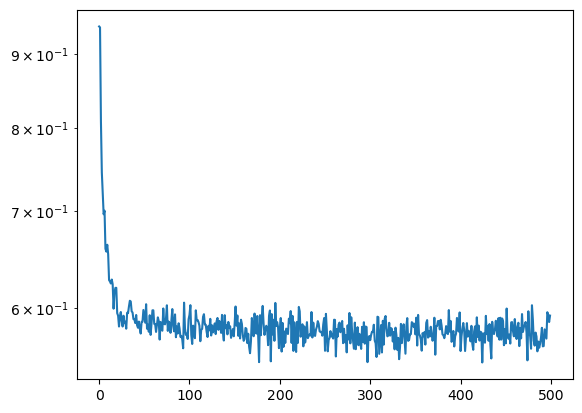

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:27,  3.02s/it]

 20%|██        | 2/10 [00:06<00:25,  3.16s/it]

 30%|███       | 3/10 [00:09<00:22,  3.15s/it]

 40%|████      | 4/10 [00:12<00:19,  3.17s/it]

 50%|█████     | 5/10 [00:15<00:15,  3.18s/it]

 60%|██████    | 6/10 [00:18<00:12,  3.17s/it]

 70%|███████   | 7/10 [00:22<00:09,  3.18s/it]

 80%|████████  | 8/10 [00:25<00:06,  3.20s/it]

 90%|█████████ | 9/10 [00:28<00:03,  3.28s/it]

100%|██████████| 10/10 [00:32<00:00,  3.34s/it]

100%|██████████| 10/10 [00:32<00:00,  3.23s/it]

Test Loss: 0.5771


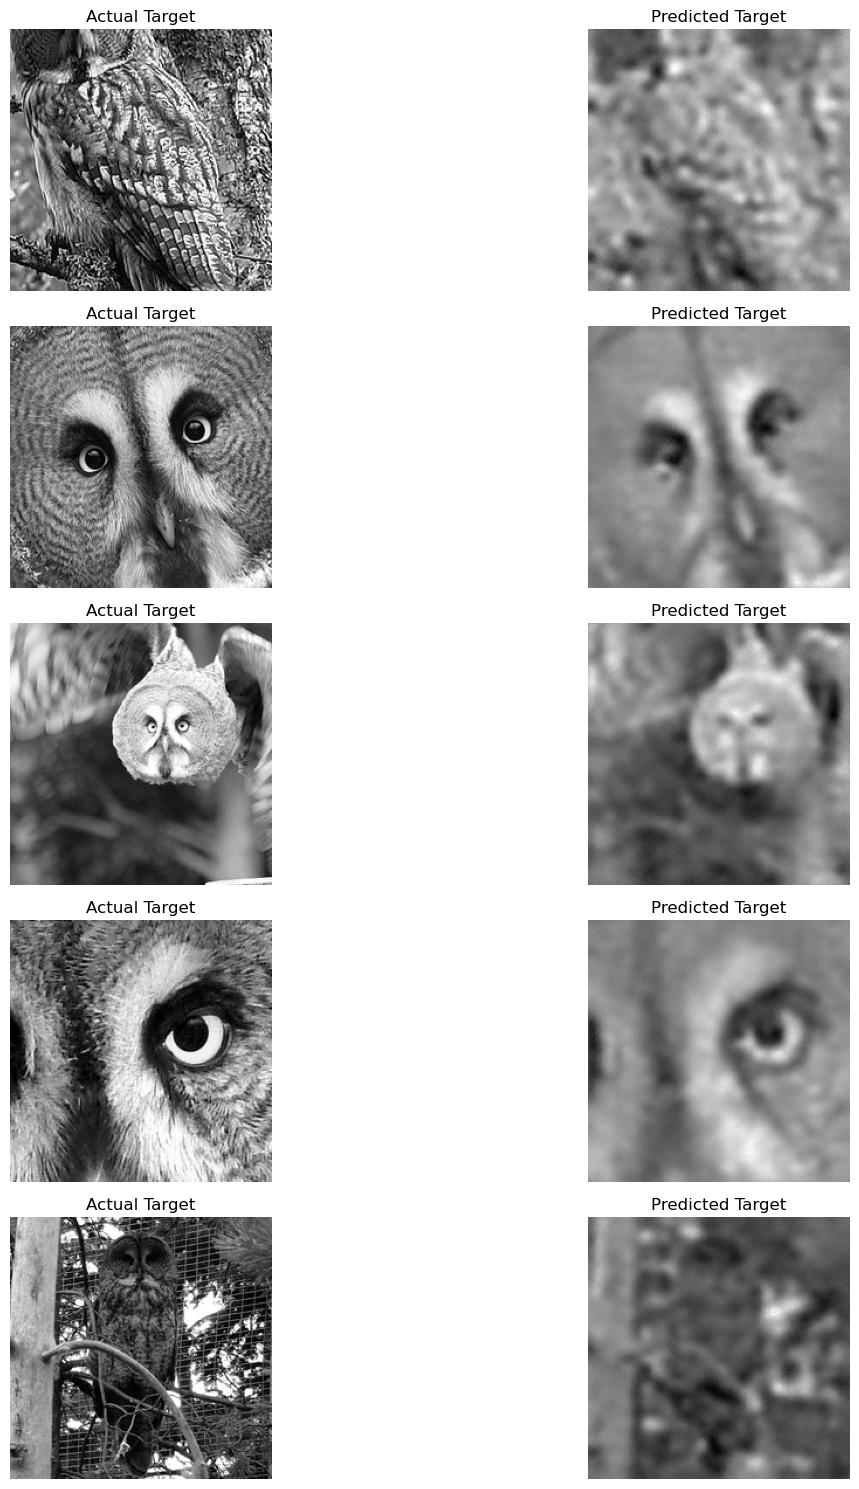

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-7.0164) tensor(6.8527)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))